In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/DSA4212_Project')

Mounted at /content/drive


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

!pip install optuna
import optuna
from optax import adamw
import pickle
import matplotlib.pyplot as plt

# local imports
import models.models_with_dropout as models
import util.generation as generation


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 31.0 MB/s eta 0:00:00


In [4]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [5]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("/content/drive/MyDrive/DSA4212_Project/data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("/content/drive/MyDrive/DSA4212_Project/data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [6]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [7]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [8]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

n lead to myocarditis inflammation of the heart muscle and death especially in newborn animals some infected animals remain asym

ight later maxwell s equations showed that light is an electromagnetic wave maxwell s equations required that all electromagneti

a or rotifers which are common in aqueous environments they also include the acanthocephala or spiny headed worms the gnathostom

 syndicalism although de leon himself made a point of distinguishing between the two ideologies de leon s insistence on a revolu

kelihood functions are equivalent if one is a scalar multiple of the other according to the likelihood principle all information



# Create a basic Transformer model

In [9]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [10]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [11]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 1_624_576


In [12]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [13]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [15]:
def train_step_with_dropout(params, opt_state, x, y, model, tx, rng):
    def loss_fn(params):
        logits = model.apply({"params": params}, x, deterministic=False, rngs={"dropout": rng})
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

train_step_with_dropout_jit = jax.jit(train_step_with_dropout, static_argnames=("model", "tx"))

# Batch creation:

In [16]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

# Hyperparameter Exploration


In [17]:
def train_with_config(learning_rate, batch_size, weight_decay, dropout_rate, n_iter=10_000):
    model = models.DecoderOnlyTransformer(
        vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads,
        max_len=max_len, dropout_rate=dropout_rate
    )

    # Initialize
    rng = jax.random.key(0)
    dummy = jnp.zeros((1, 16), dtype=jnp.int32)
    params = model.init({"params": rng}, dummy, deterministic=True)["params"]

    # Optimiser
    tx = adamw(learning_rate=learning_rate, weight_decay=weight_decay)
    opt_state = tx.init(params)

    # Track loss over time
    time_history = []
    loss_history = []
    time_start = time.time()
    dropout_rng = jax.random.key(42)

    for it in range(n_iter):
        batch = get_batch(train_text_int, batch_size, 32)
        x, y = batch[0], batch[1]

        dropout_rng, step_rng = jax.random.split(dropout_rng)
        params, opt_state, metrics = train_step_with_dropout_jit(
            params, opt_state, x, y, model, tx, step_rng
        )

        if it % 100 == 0:
            loss_history.append(float(metrics['loss']))
            time_history.append(time.time() - time_start)

    return time_history, loss_history

In [18]:
def sweep_hyperparameter(param_name, param_values, base_lr=0.001, base_bs=128,
                         base_wd=0.01, base_dr=0.1, n_iter=10_000):
    results = {}

    for val in param_values:
        print(f"Testing {param_name}={val}...")

        if param_name == 'learning_rate':
            times, losses = train_with_config(val, base_bs, base_wd, base_dr, n_iter)
        elif param_name == 'batch_size':
            times, losses = train_with_config(base_lr, val, base_wd, base_dr, n_iter)
        elif param_name == 'weight_decay':
            times, losses = train_with_config(base_lr, base_bs, val, base_dr, n_iter)
        elif param_name == 'dropout_rate':
            times, losses = train_with_config(base_lr, base_bs, base_wd, val, n_iter)

        results[val] = {'times': times, 'losses': losses}

    return results

In [19]:
def plot_sweep(results, param_name):
    plt.figure(figsize=(10, 6))
    for val, data in results.items():
        plt.plot(data['times'], data['losses'], label=f'{param_name}={val}', linewidth=2)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Loss')
    plt.title(f'Effect of {param_name} on Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Sweeping learning_rate...
Testing learning_rate=0.0001...
Testing learning_rate=0.0003...
Testing learning_rate=0.001...
Testing learning_rate=0.003...
Testing learning_rate=0.01...


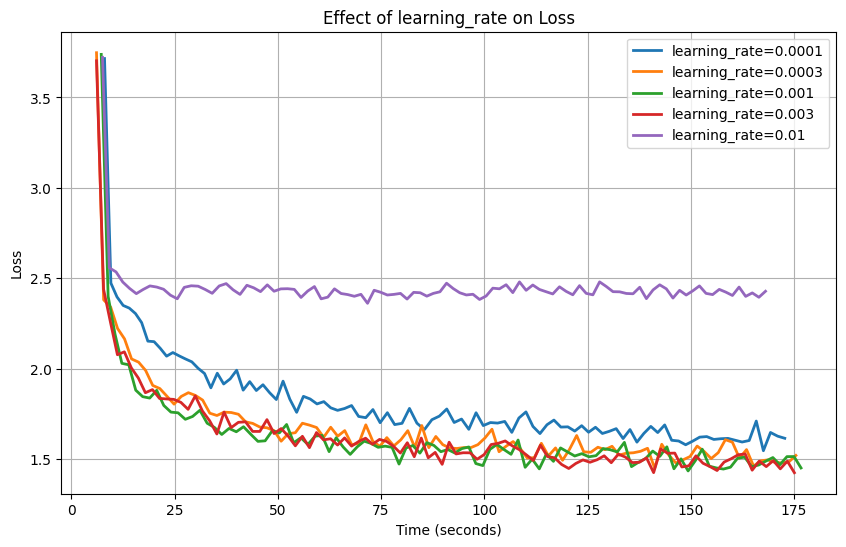


Sweeping batch_size...
Testing batch_size=32...
Testing batch_size=64...
Testing batch_size=128...
Testing batch_size=256...


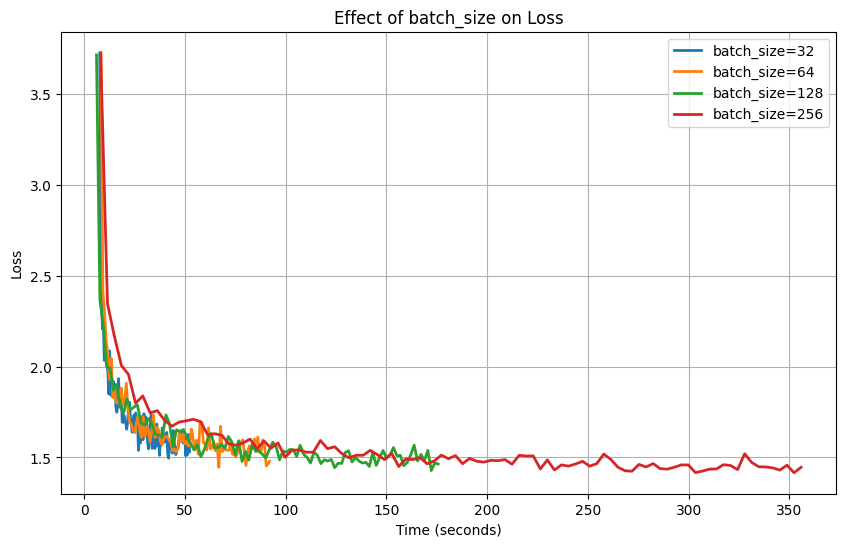


Sweeping weight_decay...
Testing weight_decay=0.0...
Testing weight_decay=0.01...
Testing weight_decay=0.05...
Testing weight_decay=0.1...


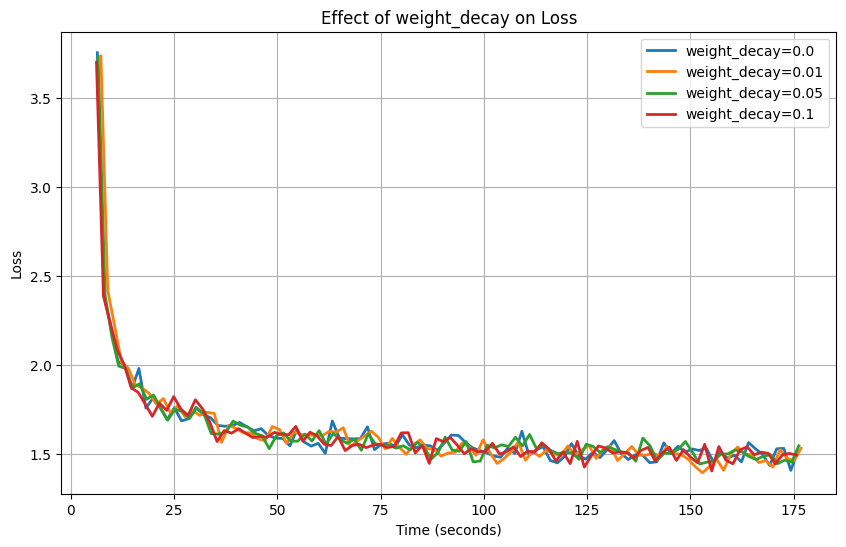


Sweeping dropout_rate...
Testing dropout_rate=0.0...
Testing dropout_rate=0.1...
Testing dropout_rate=0.2...
Testing dropout_rate=0.3...


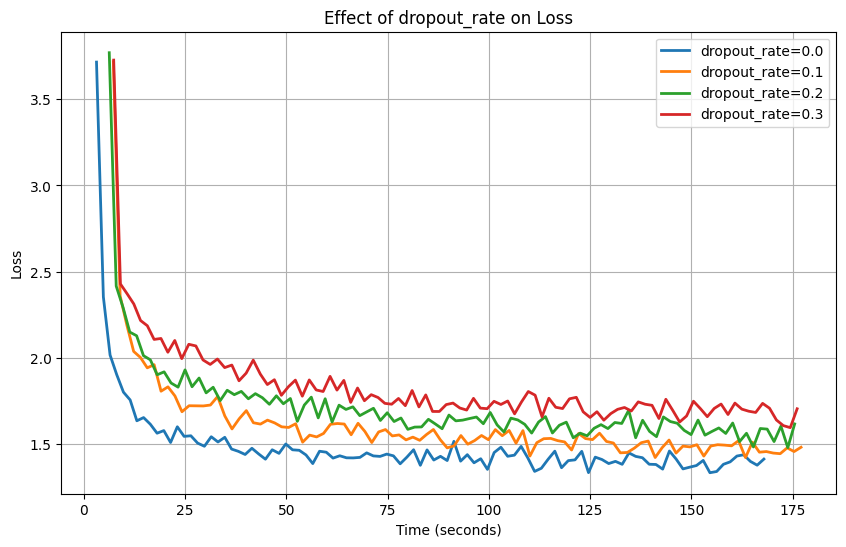

In [20]:
sweeps = {
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.01],
    'batch_size': [32, 64, 128, 256],
    'weight_decay': [0.0, 0.01, 0.05, 0.1],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3]
}

all_results = {}
for param_name, param_values in sweeps.items():
    print(f"\nSweeping {param_name}...")
    results = sweep_hyperparameter(param_name, param_values, n_iter=10_000)
    all_results[param_name] = results
    plot_sweep(results, param_name)

In [21]:
def objective(trial):
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    bs = trial.suggest_categorical('batch_size', [32, 64, 128, 256])
    wd = trial.suggest_float('weight_decay', 0.0, 0.1)
    dr = trial.suggest_float('dropout_rate', 0.0, 0.3)

    _, losses = train_with_config(lr, bs, wd, dr, n_iter=5_000)
    return losses[-1]  # Return final loss

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("\nBest hyperparameters:")
print(study.best_params)
print(f"Best loss: {study.best_value:.4f}")

[I 2025-10-31 05:14:24,518] A new study created in memory with name: no-name-bada8f78-5a9a-4e8a-82ff-62b3329317e3
[I 2025-10-31 05:15:13,705] Trial 0 finished with value: 1.82381272315979 and parameters: {'learning_rate': 0.00012054744818421497, 'batch_size': 64, 'weight_decay': 0.06056877121184676, 'dropout_rate': 0.14078603238265958}. Best is trial 0 with value: 1.82381272315979.
[I 2025-10-31 05:16:02,014] Trial 1 finished with value: 2.1258671283721924 and parameters: {'learning_rate': 6.340973504116296e-05, 'batch_size': 64, 'weight_decay': 0.08762738592005098, 'dropout_rate': 0.2887212352467588}. Best is trial 0 with value: 1.82381272315979.
[I 2025-10-31 05:16:30,687] Trial 2 finished with value: 1.7255048751831055 and parameters: {'learning_rate': 0.00024250125801491805, 'batch_size': 32, 'weight_decay': 0.04302962939318627, 'dropout_rate': 0.07994036132697156}. Best is trial 2 with value: 1.7255048751831055.
[I 2025-10-31 05:18:02,640] Trial 3 finished with value: 1.5866031646


Best hyperparameters:
{'learning_rate': 0.0008888105700559523, 'batch_size': 32, 'weight_decay': 0.006549077385255939, 'dropout_rate': 0.00608042593355268}
Best loss: 1.4502


# Training with Optuna:

In [23]:
# Train final model with best hyperparameters from Optuna
print(f"Best params: {study.best_params}")

# Extract best hyperparameters
best_lr = study.best_params['learning_rate']
best_bs = study.best_params['batch_size']
best_wd = study.best_params['weight_decay']
best_dr = study.best_params['dropout_rate']

# Create model with best dropout
model = models.DecoderOnlyTransformer(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads,
    max_len=max_len, dropout_rate=best_dr
)

# Initialize
key = jax.random.key(0)
dummy = jnp.zeros((1, 16), dtype=jnp.int32)
params = model.init({"params": key}, dummy, deterministic=True)["params"]

# Optimizer with best hyperparameters
tx = adamw(learning_rate=best_lr, weight_decay=best_wd)
opt_state = tx.init(params)

# Training loop
niter = 100_000
B, T = best_bs, 32
loss_history = []
time_history = []
loss_test_history = []
time_test_history = []
time_start = time.time()
dropout_rng = jax.random.key(42)

for it in range(niter):
    batch = get_batch(train_text_int, B, T)
    input, target = batch[0], batch[1]

    dropout_rng, step_rng = jax.random.split(dropout_rng)
    params, opt_state, metrics = train_step_with_dropout_jit(
        params, opt_state, input, target, model, tx, step_rng
    )

    loss_history.append(float(metrics['loss']))
    time_history.append(time.time() - time_start)

    if it % (niter // 50) == 0 or it == niter - 1:
        time_since_start = time.time() - time_start
        # Test evaluation
        test_batch = get_batch(test_text_int, 1024, T)
        test_input, test_target = test_batch[0], test_batch[1]
        test_logits = model.apply({"params": params}, test_input, deterministic=True)
        test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

        loss_test_history.append(float(test_loss))
        time_test_history.append(time_since_start)

        print(f"iteration {it:_}  time: {time_since_start:.1f} seconds")
        print(f"\t \t loss(train :: test): {metrics['loss']:.4f} :: {test_loss:.4f}")
        print(f"\t \t accuracy (train :: test): {100*metrics['acc']:.1f}% :: {100*test_metrics['acc']:.1f}%")
        print()

print("Training complete!")

Best params: {'learning_rate': 0.0008888105700559523, 'batch_size': 32, 'weight_decay': 0.006549077385255939, 'dropout_rate': 0.00608042593355268}
iteration 0  time: 7.1 seconds
	 	 loss(train :: test): 3.6989 :: 4.6101
	 	 accuracy (train :: test): 3.6% :: 17.0%

iteration 2_000  time: 23.1 seconds
	 	 loss(train :: test): 1.6383 :: 1.6334
	 	 accuracy (train :: test): 48.7% :: 49.9%

iteration 4_000  time: 35.8 seconds
	 	 loss(train :: test): 1.5148 :: 1.5485
	 	 accuracy (train :: test): 53.3% :: 52.2%

iteration 6_000  time: 48.0 seconds
	 	 loss(train :: test): 1.5474 :: 1.4963
	 	 accuracy (train :: test): 51.8% :: 53.8%

iteration 8_000  time: 60.2 seconds
	 	 loss(train :: test): 1.4949 :: 1.4961
	 	 accuracy (train :: test): 53.0% :: 53.7%

iteration 10_000  time: 72.6 seconds
	 	 loss(train :: test): 1.4327 :: 1.4875
	 	 accuracy (train :: test): 55.4% :: 54.0%

iteration 12_000  time: 84.5 seconds
	 	 loss(train :: test): 1.4274 :: 1.4593
	 	 accuracy (train :: test): 55.8%

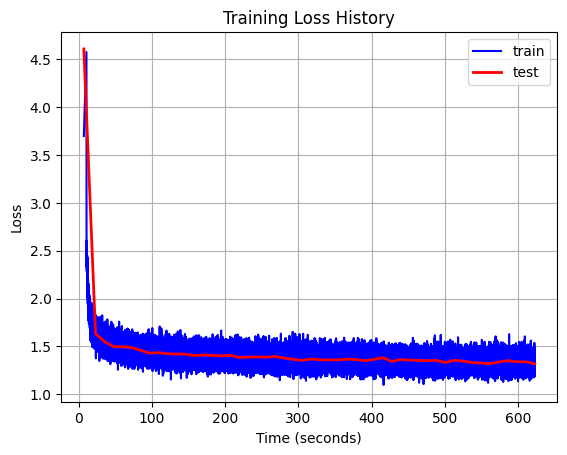

In [24]:
# plot the loss history
import matplotlib.pyplot as plt
plt.plot(time_history, loss_history, '-', label='train', color="blue")
plt.plot(time_test_history, loss_test_history, '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()

In [25]:
B = 1
seed = 42
rng = jax.random.PRNGKey(seed)
prompt = "hello my fri"
# prompt_int = encode(prompt.lower())
prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

gen_len = 1000
out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
                          temperature=0.7, sample=True)
print('generated ids shape:', out_ids.shape)
print('generated text:')
generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# concatenate with prompt
print(prompt + generated_text)
#print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))

generated ids shape: (1, 1000)
generated text:
hello my fri illllllido ase on sh ad ffffraleniandand benofrp estonon stc and cem ca d muloveus morrrt mearari aschashort sererardrilead kind and gerad fungus ar ich ff fffad trr olashauiend wastelequstuguin anond iatere cet itured offffor d pperidofe id wongunarnolencerme ar sinc pisphoup cond rs is ces ges a cun hechos f seshanichas on ar siend sthen ta ast oneas iceend mondrepelarmarlideri aronsima flinericollanthe s antied a ous bor ar pero icicenstholinolaseceiegaris ananeviliame bil one h ibies hies th bor h attt s iseigns an c mad c t guth armeverigear iariceanar st s unic tund chant d se y a telerilil rmmis rracond mar tr and fand angus iem ratis onanona arrir lligebbiastrare s enge h shonceges tzis fa ie oustyenerinep s m antharlad garar tararnim anus s cl armaranos agutens cor cheponacoris achel as couli concand an ts arlaricolhy ond on eshamphond t ss cus merengnghononond shol anonic emen chas micor s wenina we s fid jerron fffe